In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# URL del archivo en el bucket público de AWS
url = "https://hybridge-education-machine-learning-datasets.s3.us-east-1.amazonaws.com/Fraud.csv"
df = pd.read_csv(url)

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
len(df)

6362620

# ¡¡¡6,362,620 OBSERVACIONES!!!

In [1]:
# --- 1) Imports y lectura de datos ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, average_precision_score
)

url = "https://hybridge-education-machine-learning-datasets.s3.us-east-1.amazonaws.com/Fraud.csv"
df = pd.read_csv(url)

print(df.shape)
df.head()



(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
# --- 2) EDA 
fraud_rate = df["isFraud"].mean()
print(f"Fraud rate: {fraud_rate:.4%}")  # suele ser MUY bajo

# --- 3) 
# Eliminamos identificadores textuales (no informativos por sí solos)
drop_ids = ["nameOrig", "nameDest"]

# Errores/consistencias de balances (útiles en este dataset)
df["errOrig"] = df["newbalanceOrig"] + df["amount"] - df["oldbalanceOrg"]
df["errDest"] = df["oldbalanceDest"] + df["amount"] - df["newbalanceDest"]

# Cambios de balance
df["deltaOrig"] = df["newbalanceOrig"] - df["oldbalanceOrg"]
df["deltaDest"] = df["newbalanceDest"] - df["oldbalanceDest"]

# (opcional) ratios acotados
df["amt_over_oldOrig"] = (df["amount"] / (1 + df["oldbalanceOrg"])).clip(0, 10)

# --- 4) Definir X, y ---
target = "isFraud"
X = df.drop(columns=[target] + drop_ids)
y = df[target]

# Columnas categóricas y numéricas
cat_cols = ["type"]               # (PAYMENT, TRANSFER, CASH_OUT, etc.)
num_cols = [c for c in X.columns if c not in cat_cols]

# --- 5) Train/Test split estratificado (por desbalance) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),  # with_mean=False por seguridad si hay esparsidad
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

logreg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",   
    n_jobs=None                 
)

pipe = Pipeline([
    ("prep", preprocess),
    ("clf", logreg),
])

pipe.fit(X_train, y_train)


Fraud rate: 0.1291%


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Confusion matrix (thr=0.5):


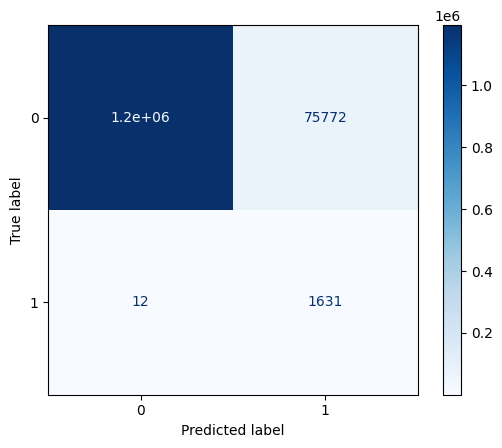

              precision    recall  f1-score   support

           0     1.0000    0.9404    0.9693   1270881
           1     0.0211    0.9927    0.0413      1643

    accuracy                         0.9404   1272524
   macro avg     0.5105    0.9665    0.5053   1272524
weighted avg     0.9987    0.9404    0.9681   1272524



AttributeError: 'float' object has no attribute 'round'

In [3]:
# --- 7) Evaluación con umbral 0.5 ---
y_prob = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("Confusion matrix (thr=0.5):")
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot(cmap="Blues"); plt.show()

print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob).round(4))
print("Average Precision (PR AUC):", average_precision_score(y_test, y_prob).round(4))


Mejor umbral por F1: 0.99 | F1=0.5409 | Prec=0.5268 | Rec=0.5557

Reporte con umbral óptimo (F1):
              precision    recall  f1-score   support

           0     0.9994    0.9994    0.9994   1270881
           1     0.5268    0.5557    0.5409      1643

    accuracy                         0.9988   1272524
   macro avg     0.7631    0.7775    0.7701   1272524
weighted avg     0.9988    0.9988    0.9988   1272524



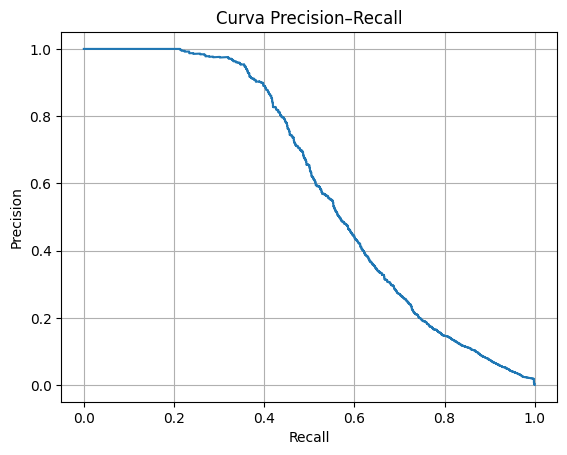

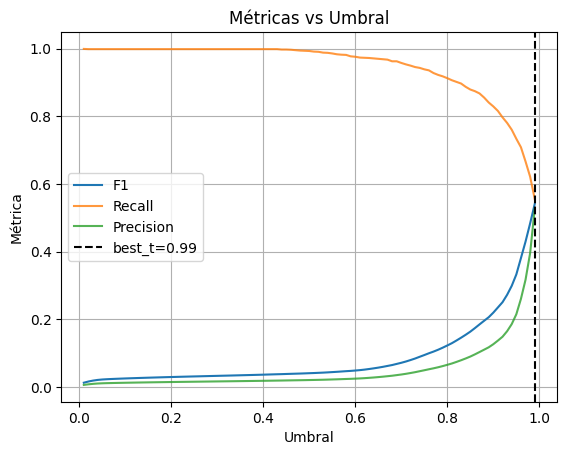

In [4]:
# --- 8) (Opcional) Optimizar umbral según F1 o para más recall ---
ths = np.linspace(0.01, 0.99, 99)
f1s, recs, precs = [], [], []
for t in ths:
    yp = (y_prob >= t).astype(int)
    f1s.append(f1_score(y_test, yp, zero_division=0))
    recs.append(recall_score(y_test, yp, zero_division=0))
    precs.append(precision_score(y_test, yp, zero_division=0))

best_t = ths[np.argmax(f1s)]
print(f"Mejor umbral por F1: {best_t:.2f} | F1={max(f1s):.4f} | "
      f"Prec={precs[np.argmax(f1s)]:.4f} | Rec={recs[np.argmax(f1s)]:.4f}")

# Métricas con umbral óptimo
y_pred_best = (y_prob >= best_t).astype(int)
print("\nReporte con umbral óptimo (F1):")
print(classification_report(y_test, y_pred_best, digits=4))

# Curva Precision-Recall
prec, rec, thr = precision_recall_curve(y_test, y_prob)
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Curva Precision–Recall")
plt.grid(True); plt.show()

# Umbral vs F1/Recall (visual rápido)
plt.plot(ths, f1s, label="F1")
plt.plot(ths, recs, label="Recall", alpha=0.8)
plt.plot(ths, precs, label="Precision", alpha=0.8)
plt.axvline(best_t, ls="--", c="k", label=f"best_t={best_t:.2f}")
plt.legend(); plt.xlabel("Umbral"); plt.ylabel("Métrica"); plt.title("Métricas vs Umbral")
plt.grid(True); plt.show()
